In [11]:
# importing necessary packages
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook
import seaborn as sns

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
# loading dataset
train_csv = pd.read_excel('../input/drnoman1000/trainLabels.xlsx')
#test_csv = pd.read_excel('/content/drive/MyDrive/DR_Noman/testLabels.xlsx')

In [14]:
print('Train Size = {}'.format(len(train_csv)))
#print('Test Size = {}'.format(len(test_csv)))

Train Size = 1000


In [15]:
train_csv.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [16]:
#test_csv.head()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


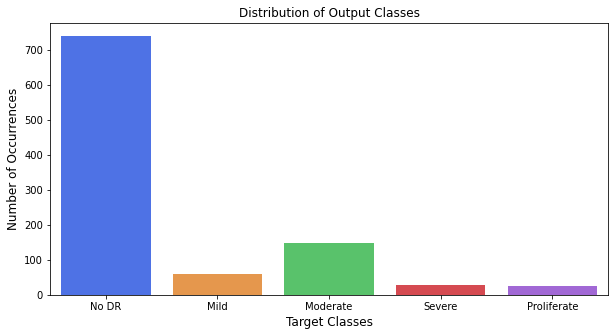

In [17]:
# EDA
counts = train_csv['level'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [18]:
#unzipping training data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_3000/train.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_3000')
#zf.close()

In [19]:
# image count in training folder
dir_path = r'../input/drnoman1000/train/train'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 1000


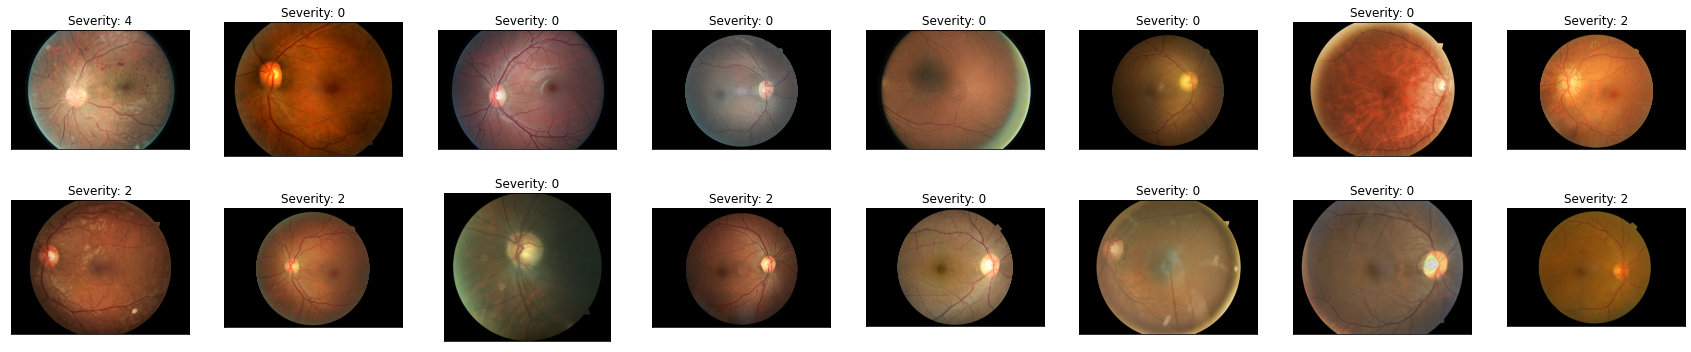

In [20]:
# display 16 images from training set
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(dir_path)
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(dir_path + "/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['image'] == img.split('.')[0], 'level'].values[0]
    ax.set_title('Severity: %s'%lab)

In [21]:
#unzipping testing data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_Updated/test.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_Updated')
#zf.close()

In [22]:
# image count in testing folder
#dir_path = r'/content/drive/MyDrive/DR_Noman_Updated/test'
#count = 0
# Iterate directory
#for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        #count += 1
#print('File count:', count)

In [23]:
# display 16 images from testing set
#fig = plt.figure(figsize=(30, 6))
#test_imgs = os.listdir(dir_path)
#for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    #ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    #im = Image.open(dir_path+ "/" + img)
    #plt.imshow(im)

In [24]:
#print(os.listdir("/content/drive/MyDrive"))
base_dir = "../input/drnoman1000"

In [25]:
print(os.listdir(base_dir))

['trainLabels.xlsx', 'train']


In [26]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.jpeg')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [27]:
# data augmentation
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [28]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [29]:
train_path = "../input/drnoman1000/train/train"
#test_path = "/content/drive/MyDrive/DR_Noman_Updated/test/"

In [30]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
#test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [31]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [32]:
num_train

1000

In [33]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [34]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [35]:
print(f"training examples contain : {len(train_data)}")
#print(f"testing examples contain : {len(test_data)}")

print(f"train loader contain : {len(trainloader)}")
print(f"valid loader contain : {len(validloader)}")
#print(len(trainloader))
#print(len(validloader))
#print(len(testloader))

training examples contain : 1000
train loader contain : 13
valid loader contain : 4


In [36]:
# LOAD ONE BATCH OF Training SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 3, 0, 0,
        2, 0, 0, 2, 1, 2, 1, 0, 0, 4, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0])


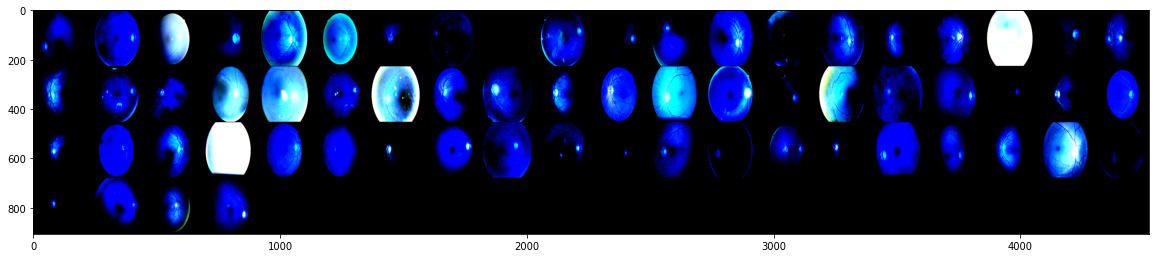

In [37]:
# plotting the images of loaded batch with given fig size and frame data    
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

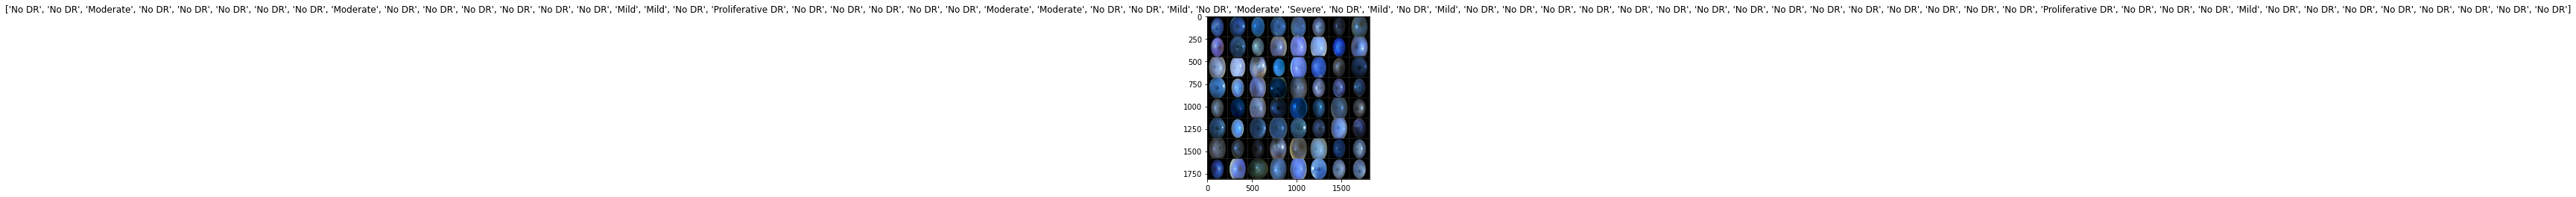

In [38]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [39]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [41]:
#model_save_name = 'DR_classifier_Noman_ResNet152.pt'
#torch.save(model.state_dict()), f".//{model_save_name}")
torch.save(model.state_dict(), 'DR_classifier_Noman_ResNet18.pth')

In [42]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [43]:
#optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [44]:
path = "./DR_classifier_Noman_ResNet18.pth"
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [45]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [46]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
11284229


In [48]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [49]:
import time
t0 = time.time()

In [ ]:
train_losses, valid_losses, acc = train_and_test(10)
print("Training time:", time.time()-t0)

Model Training started.....
 epoch 1 batch 10 completed
validation started for 1
Epoch: 1/10..  Training Loss: 1.056..  Valid Loss: 0.663..  Valid Accuracy: 0.809
Validation loss decreased (inf --> 0.663207).  Saving model ...
 epoch 2 batch 10 completed
validation started for 2
Epoch: 2/10..  Training Loss: 0.754..  Valid Loss: 0.658..  Valid Accuracy: 0.781
Validation loss decreased (0.663207 --> 0.658399).  Saving model ...
 epoch 3 batch 10 completed
validation started for 3
Epoch: 3/10..  Training Loss: 0.599..  Valid Loss: 0.623..  Valid Accuracy: 0.836
Validation loss decreased (0.658399 --> 0.622639).  Saving model ...
 epoch 4 batch 10 completed
validation started for 4
Epoch: 4/10..  Training Loss: 0.474..  Valid Loss: 0.798..  Valid Accuracy: 0.781
 epoch 5 batch 10 completed
validation started for 5
Epoch: 5/10..  Training Loss: 0.354..  Valid Loss: 0.959..  Valid Accuracy: 0.781
 epoch 6 batch 10 completed
validation started for 6
Epoch: 6/10..  Training Loss: 0.248..  Val

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)